In [75]:
import os
import matplotlib.pyplot as plt

import numpy as np
import chainer

import pickle as pkl
import matplotlib
import math

from torch.autograd import Variable
from torch.nn import RNN, GRU, LSTM, Linear, Embedding
from tqdm import tqdm
from torch import nn
import torch
from keras.utils import to_categorical

import lyapunov as l
from importlib import reload  # Python 3.4+ only.
import gc
import sys
from math import floor
from importlib import reload
from matplotlib import cm
from matplotlib.lines import Line2D
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib

from random import random
from random import seed

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
import os.path as path

import dataloader as dl

In [23]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
class Config:
    def __init__(self, data_dir = 'CharRNN/WP/HP', rnn_model = 'lstm', hidden_size = 128, num_layers = 1, dropout = 0.0, learning_rate = .002, embedded = 'one-hot',
                 seq_length = 100, batch_size= 100, max_epochs = 50, decay_rate = 0.95, decay_start = 10, train_frac = 0.8, val_frac = 0.1, cuda = torch.cuda.is_available(), model_dir = 'CharRNN/WP/HP/Models',
                 print_interval = 100, optimizer = 'adam'):
        
        self.data_dir = data_dir 
        
        self.rnn_model = rnn_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedded = embedded
        
        self.learning_rate = learning_rate #initial learning rate
        self.optimizer = optimizer
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.decay_rate = decay_rate
        self.decay_start = decay_start
        self.train_frac = train_frac
        self.val_frac = val_frac
        
        self.cuda = cuda
        self.model_dir = model_dir
        self.full_name = "{}_L{}_H{}_drop{}_{}_lr{}".format(self.rnn_model, self.num_layers, self.hidden_size, self.dropout, self.learning_rate, self.optimizer)
#         self.full_name = "{}_L{}_H{}_drop{}_{}".format(self.rnn_model, self.num_layers, self.hidden_size, self.dropout, self.optimizer)

        self.print_interval = print_interval

## Data Preprocessing

In [3]:
con = Config()
train_set, val_set, test_set, (char_to_int, int_to_char) = dl.create_dataset(con)
train_input_set, train_target_set = train_set[0], train_set[1]
val_input_set, val_target_set = val_set[0], val_set[1]
test_input_set, test_target_set = test_set[0], test_set[1] 
vocab_size = len(char_to_int)

Loading  CharRNN/WP/HP\data.pkl ...
Loading  CharRNN/WP/HP\vocab.pkl ...
None
Cutting off end of data so that it divides evenly
Data load done! Number of data batches in train: 256, val: 32, test: 31


In [4]:
rnn_sizes = [157, 289, 549]
lstm_sizes = [64, 128, 256, 512]
gru_sizes = [78, 153, 301, 597]

In [ ]:
val_input_set.shape

In [5]:
val_input_set = torch.cat((val_input_set, test_input_set), dim=0)
val_target_set = torch.cat((val_target_set, test_target_set), dim=0)
val_set = (val_input_set, val_target_set)

## Create Model Template, Train and Validation functions

In [4]:
# build the model using the pytorch nn module
class CharRNN(nn.ModuleList):
    def __init__(self, num_layers, vocab_size, hidden_size, model = 'lstm', p_drop = 0.0, embedded = 'one-hot', dynamics = False, cuda = torch.cuda.is_available()):
        super(CharRNN, self).__init__()
        
        # init the meta parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.model = model
        self.L = self.num_layers*self.hidden_size
        self.dynamics = dynamics
        self.embedded = embedded
        self.device = torch.device('cuda') if cuda else torch.device('cpu')
        
        if self.embedded == None:
            self.encoder = nn.Identity()
        elif self.embedded == 'embedding':
            self.encoder = Embedding(input_size, input_size)
        elif self.embedded == 'one-hot':
            self.encoder = lambda xt: torch.from_numpy(to_categorical(xt.cpu(), self.vocab_size)).to(self.device)
        else:
            raise Exception('Embedding type not defined')
            
            
        if model == 'rnn':
            self.rnn_layer = RNN(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = hidden_size
        elif model == 'gru':
            self.rnn_layer = GRU(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 3*hidden_size
        elif model == 'lstm':
            self.rnn_layer = LSTM(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 4*hidden_size
        else:
            raise Exception('Recurrent model not defined. Exitting.')
        
        #Initialize weights to all be between -0.08 and 0.08 
        for layer_p in self.rnn_layer._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    nn.init.uniform_(self.rnn_layer.__getattr__(p), -0.08, 0.08)
        
        self.dropout = nn.Dropout(p=p_drop)
        self.fc = Linear(in_features = hidden_size, out_features = vocab_size, bias = False)
        
    def forward(self, xt, h):
        encoded = self.encoder(xt)
        self.rnn_layer.flatten_parameters()
        rnn_out, rnn_hn = self.rnn_layer(encoded, h)
        d_out = self.dropout(rnn_out)
        output = self.fc(d_out)
        return output, rnn_hn
    
    
    def init_hidden(self, batch_size):
        if self.model == 'lstm':
            if self.dynamics:
                return (Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device))
            else:
                return (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(self.device))

        if self.dynamics:
            return Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device)
        else:
            return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)


In [5]:
def train_hp(train_set, val_set, vocab_size, config, init_epoch = 0, save_losses = True):
    device = torch.device('cuda') if config.cuda else torch.device('cpu')
    char_rnn = CharRNN(vocab_size = vocab_size, num_layers= config.num_layers, hidden_size = config.hidden_size, model = config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
    
    # train_input_set : (train_batches, batch_size, seq_length); the rest are similar
    train_input_set, train_target_set = train_set[0], train_set[1]
    val_input_set, val_target_set = val_set[0], val_set[1]
    
    
    criterion = nn.CrossEntropyLoss()   # include softmax
    if config.optimizer == 'rms':
        optimizer = torch.optim.RMSprop(params = char_rnn.parameters(), lr = config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = torch.optim.Adam(params = char_rnn.parameters(), lr = config.learning_rate)
    else:
        print(config.optimizer +'is not a recognized optimizer')
        return
    # learning rate decay
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = range(config.decay_start-init_epoch, config.max_epochs+1-init_epoch) , gamma = config.decay_rate)
    
    best_val_loss = sys.float_info.max
    
    train_losses = []
    if init_epoch == 0:
        torch.save(char_rnn.state_dict(), path.join(config.model_dir, "{}_e0.pth".format(config.full_name)))
    else:
        char_rnn.load_state_dict(torch.load(path.join(config.model_dir, config.full_name)+'_e{}.pth'.format(hp_epoch)))
    for epoch_idx in tqdm(range(init_epoch+1, config.max_epochs + 1)): # for evary epoch
#             print("Training for %d epochs..." % epoch_idx)
        running_loss = 0.0
    
    # initialize hidden states for every epoch
        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()
        
        for batch_idx in range(1, train_input_set.shape[0] + 1):   # for every batch
            # for every batch
            optimizer.zero_grad()   # zero the parameter gradients

            train_input = train_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                train_input = train_input.cuda()
            
            xt = Variable(train_input)
            # compute loss for this batch
            loss = 0
#                 for i in range(config.seq_length):  # for every time step in this batch
            # forward pass
#             print('xt shape: ' + str(xt.shape))
            train_output, hidden = char_rnn(xt, hidden) # ignore gate values
            # add up loss at each time step
            loss += criterion(train_output.view(-1, vocab_size), Variable(train_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
#             loss += criterion(train_output.view(config.batch_size, -1).cpu(),
#                               Variable(train_target_set[batch_idx - 1]))

#             detach hidden state from current computational graph for back-prop
            if config.rnn_model == 'lstm':
                for x in hidden:
                    x.detach_()
            else:
                hidden.detach_()

            # backward
            loss.backward()
            optimizer.step()
            

            # print statistics
            running_loss += loss.item()
#             if batch_idx % config.print_interval == 0:  # print_interval batches
#                 print('[%d, %4d] loss: %.3f' % (epoch_idx, batch_idx, running_loss / config.print_interval))
#                 running_loss = 0.0

            '''
            # validate model
            val_loss = 0
            # for every batch
            for val_batch_idx in range(1, val_input_set.shape[0] + 1):
                val_input = val_input_set[val_batch_idx - 1]
                # ship to gpu if possible
                if torch.cuda.is_available() and config.cuda:
                    val_input = val_input.cuda()
                for i in range(config.seq_length):  # for every time step in this batch
                    # forward pass
                    val_output, _, _ = char_rnn(Variable(val_input[:, i]), hidden)
                    # add up loss at each time step
                    val_loss += criterion(val_output.view(config.batch_size, -1).cpu(),
                                          Variable(val_target_set[val_batch_idx - 1][:, i]))
            val_loss /= val_input_set.shape[0]  # loss per batch
            print('Validation loss: %.3f' % val_loss)
            # save the best model sofar
            if val_loss.data[0] < best_val_loss:
                print('Saving model [%d, %4d]...' % (epoch_idx, batch_idx))
                torch.save(char_rnn.state_dict(), path.join(config.model_dir, config.model + '.pth'))
                # to load a saved model: char_rnn = CharRNN(*args, **kwargs), char_rnn.load_state_dict(torch.load(PATH))
                best_val_loss = val_loss.data[0]
            '''

        train_losses.append(running_loss/(train_input_set.shape[0] + 1))
#         print('Epoch %d Training Loss: %4f' % (epoch_idx, train_losses[epoch_idx-1]))
        scheduler.step()    # lr decay
        # save model after each epoch
        torch.save(char_rnn.state_dict(), path.join(config.model_dir, config.full_name +"_e{}.pth".format(epoch_idx)))
    if save_losses:
        pkl.dump(train_losses, open(path.join(config.model_dir, config.full_name+"_trainLoss.p"), 'wb'))
    return char_rnn

In [6]:
def best_fit_slope(x,y):
#     m = np.mean(ys)
    xs = torch.Tensor(x)
    ys = torch.Tensor(y)
    m = (((torch.mean(xs)*torch.mean(ys)) - torch.mean(xs*ys)) /
         ((torch.mean(xs)**2) - torch.mean(xs**2)))
    return m

In [7]:
def le_loss(net, con, slope_inds, dynamics = False):
    net.dynamics = dynamics
    batch_size, seq_length = con.batch_size, con.seq_length
    xt_flat = torch.flatten(test_input_set)[:batch_size * seq_length * math.floor(test_input_set.nelement() / (batch_size * seq_length))]
    idx = torch.randperm(xt_flat.nelement())
    test_dr = torch.from_numpy(to_categorical(xt_flat[idx].view(-1, batch_size, seq_length), vocab_size)).to(device)
    i = torch.randint(low = 0, high = test_dr.shape[0], size =  (1,)).item()


    # net.load_state_dict(torch.load(path.join(con.model_dir, "Models/" + con.full_name)+'_e{}.pth'.format(epoch)))
    h_l = net.init_hidden(con.batch_size)
    LE_char, _ = l.calc_LEs_an(test_dr[i], h_l, model = net, k_LE = 10000, rec_layer = con.rnn_model)
    
    LE_mean, LE_std = l.LE_stats(LE_char)
    slopes = best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LE_mean[slope_inds[0]:slope_inds[1]]))
    net.dynamics = False
    return slopes, (LE_mean, LE_std)

In [8]:
def model_idx(idx):
    if idx == [0]:
        return 'lstm', 512, 'l'
    elif idx == [1]:
        return 'gru', 597, 'g'
    elif idx == [2]:
        return 'rnn', 549, 'r'

In [9]:
def val_epoch(config, val_set, vocab_size, epoch):
    criterion = nn.CrossEntropyLoss()   # include softmax
    if torch.cuda.is_available() and config.cuda:
        device = torch.device('cuda')
    val_input_set, val_target_set = val_set[0], val_set[1]
    
    char_rnn = CharRNN(config.num_layers, vocab_size, config.hidden_size, model=config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
    char_rnn.load_state_dict(torch.load(path.join(config.model_dir, config.full_name)+'_e{}.pth'.format(epoch)))
    running_loss = 0.0

    hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
    # ship to gpu if possible
    if torch.cuda.is_available() and config.cuda:
        if config.rnn_model == 'lstm':
            hidden = tuple([x.cuda() for x in hidden])
        else:
            hidden = hidden.cuda()

    for batch_idx in range(1, val_input_set.shape[0] + 1):   # for every batch
#         print(batch_idx)
        # for every batch
        val_input = val_input_set[batch_idx - 1]

        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            val_input = val_input.cuda()

        xt = Variable(val_input)
        # compute loss for this batch
        loss = 0
        val_output, hidden = char_rnn(xt, hidden)
        # add up loss at each time step
        loss += criterion(val_output.view(-1, vocab_size), Variable(val_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
        running_loss += loss.item()
    pkl.dump(running_loss/(val_input_set.shape[0] + 1), open(path.join(config.model_dir, config.full_name+"_e{}_valLoss.p".format(epoch)), 'wb'))
    return running_loss/(val_input_set.shape[0] + 1)

In [10]:
def val(config, val_set, vocab_size):
    criterion = nn.CrossEntropyLoss()   # include softmax
    if torch.cuda.is_available() and config.cuda:
        device = torch.device('cuda')
    val_losses = []
    val_input_set, val_target_set = val_set[0], val_set[1]
    for epoch in tqdm(range(config.max_epochs)):
        char_rnn = CharRNN(config.num_layers, vocab_size, config.hidden_size, model=config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
        char_rnn.load_state_dict(torch.load(path.join(config.model_dir, config.full_name)+'_e{}.pth'.format(epoch)))
        running_loss = 0.0

        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()

        for batch_idx in range(1, val_input_set.shape[0] + 1):   # for every batch
            # for every batch
            val_input = val_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                val_input = val_input.cuda()

            xt = Variable(val_input)
            # compute loss for this batch
            loss = 0
            val_output, hidden = char_rnn(xt, hidden)
            # add up loss at each time step
            loss += criterion(val_output.view(-1, vocab_size), Variable(val_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
            running_loss += loss.item()
        val_losses.append(running_loss/(val_input_set.shape[0] + 1))
    pkl.dump(val_losses, open(path.join(config.model_dir, config.full_name+"_valLossFull.p"), 'wb'))
    return val_losses

# Optimize over LE Slope

In [11]:
optim_epochs = 1
optim_seq_len = 100
dropout = .2
size = 512
model = 'lstm'
optim = 'adam'

test_input_set, test_target_set = test_set[0], test_set[1]
# con = Config(model_dir = 'CharRNN/WP/HP/Models/Shallow', dropout = dropout, max_epochs = optim_epochs, batch_size = 25, decay_rate = .95, hidden_size = size, seq_length = optim_seq_len, rnn_model = model, optimizer = optim)
# net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)



## Conducting New Search

In [ ]:
def objective(net_parameters, slope_indices = [50, 100], max_epochs = 4):
    
    con = Config(model_dir = model_dir, data_dir = model_dir, rnn_model=net_parameters['model'], hidden_size = net_parameters['size'], 
                 dropout = net_parameters['dropout'], learning_rate= net_parameters['learning_rate'], max_epochs = max_epochs, batch_size = 100)
    net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
    train_hp(train_set, val_set, vocab_size, con)
    net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(max_epochs)))
    con.batch_size = 10
    loss, LEs = le_loss(net, con, slope_indices, dynamics = False)
    pkl.dump(LEs, open(path.join(con.model_dir, con.full_name+'_e{}_LEStats.p'.format(con.max_epochs)), 'wb'))
    return {
        'loss': loss,
        'status' : STATUS_OK,
        'net': net
    }

In [ ]:
def objective2(net_parameters, slope_indices = [50, 100], max_epochs = 4):
    
    con = Config(rnn_model=net_parameters['model'], hidden_size = net_parameters['size'], model_dir = 'CharRNN/WP/HP/Models/Shallow',
                 dropout = net_parameters['dropout'], learning_rate= net_parameters['learning_rate'], max_epochs = max_epochs, batch_size = 100)
    net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
    train_hp(train_set, val_set, vocab_size, con)
    net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(max_epochs)))
    con.batch_size = 10
    loss, LEs = le_loss(net, con, slope_indices, dynamics = False)
    pkl.dump(LEs, open(path.join(con.model_dir, con.full_name+'_e{}_LEStats.p'.format(con.max_epochs)), 'wb'))
    return {
        'loss': abs(loss),
        'status' : STATUS_OK,
        'net': net
    }

In [ ]:
do_lb = -9
network_space = hp.choice('net_settings', [
    {
        'model': 'lstm',
        'size': 512,
        'dropout': hp.qloguniform('do_l', do_lb,0, 1e-3),
        'learning_rate': hp.qloguniform('lr_l', -7.5, -5, 1e-5)
    },
#     {
#         'model': 'gru',
#         'size' : 597,
#         'dropout': hp.qloguniform('do_g', do_lb, 0, 1e-3),
#         'learning_rate': hp.qloguniform('lr_g', -7.5, -5, 1e-5)
#     },
#     {
#         'model': 'rnn',
#         'size': 549,
#         'dropout': hp.qloguniform('do_r', do_lb, 0, 1e-3),
#         'learning_rate': hp.qloguniform('lr_r', -7.5, -5, 1e-5)
#     },
    ])

In [ ]:
trials_shallow = Trials()
# trials = Trials()

In [ ]:
trials = Trials()
model_dir = 'CharRNN/WP/HP/Models/LSTM'
data_dir = model_dir

In [ ]:
best = fmin(objective, 
            space = network_space, 
            algo = tpe.suggest,
            trials = trials,
            max_evals = 60
           )

pkl.dump(trials, open(con.data_dir + '/hpTrials5.p', 'wb'))

In [ ]:
best = fmin(objective2, 
            space = network_space, 
            algo = tpe.suggest,
            trials = trials_shallow,
            max_evals = 10
           )

pkl.dump(trials_shallow, open(con.model_dir + '/hpTrials1_2.p', 'wb'))

In [ ]:
trials

## Post-Processing

In [14]:
model_dir = 'CharRNN/WP/HP/LSTM'

In [15]:
trials = pkl.load(open(model_dir + '/hpTrials5.p', 'rb'))

In [16]:
n = len(trials)
r_idcs = np.array(range(math.floor(n/6)*6))
np.random.shuffle(r_idcs)
r_idcs = np.reshape(r_idcs, (-1, 6))

In [ ]:
tls = np.array(trials.losses())
# steepest = np.where(tls < -.00185)[0]
# shallowest = np.where(tls > -.0014)[0]

In [ ]:
# len(shallowest)

In [17]:
models = []
lrs = []
dos = []

for trial in trials.trials:
    m = trial['misc']['vals']['net_settings']
    models.append(m)
    ls = trial['misc']['vals']['lr_l']
#     ls = [trial['misc']['vals']['lr_l'], trial['misc']['vals']['lr_g'], trial['misc']['vals']['lr_r']][m[0]]
    lrs.append(ls)
    do = trial['misc']['vals']['do_l']
#     do = [trial['misc']['vals']['do_l'], trial['misc']['vals']['do_g'], trial['misc']['vals']['do_r']][m[0]]
    dos.append(do)
    
dos = np.array(dos).T.squeeze()
lrs = np.array(lrs).T.squeeze()

In [18]:
overwritten = []
for t_id, do, lr, model in zip(range(len(trials)), dos, lrs, models):
#     print('{} with Dropout {} at indices'.format(model, do))
    ind_check1 = np.intersect1d(np.where(np.array(models) == model), np.where(dos == do))
    ind_check2 = np.intersect1d(np.where(np.array(models) == model), np.where(lrs == lr))
    ind_check = np.intersect1d(ind_check1, ind_check2)
    if t_id < ind_check[-1]:
        overwritten.append(t_id)
        print('Trial {} with dropout {} overwritten by trial {}'.format(t_id, do, ind_check[-1]))
#     else:
#         print('Trial {} with dropout {} not overwritten'.format(t_id, do, ind_check[-1]))

print(overwritten)
# print('\nShallowest Trials:')
# for t_id, do, model in zip(shallowest, do_shallow, model_shallow):
#     print('{} with Dropout {} at indices'.format(model, do))
#     ind_check = np.intersect1d(np.where(np.array(models) == model), np.where(dos == do))
#     if t_id < ind_check[-1]:
#         t_id
#         print('Trial {} with dropout {} overwritten by trial {}'.format(t_id, do, ind_check[-1]))
#     else:
#         print('Trial {} with dropout {} not overwritten'.format(t_id, do, ind_check[-1]))

[]


## Training and Validation

In [16]:
hp_epoch = 4
max_epochs = 15
model_dir = 'CharRNN/WP/HP/Models/LSTM'
for idx in range(len(trials)):
    t_vals = trials.trials[idx]['misc']['vals']
    net_type, size, suf = model_idx(t_vals['net_settings'])
    
    con = Config(rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], 
                 optimizer = 'adam', max_epochs = max_epochs, model_dir = model_dir)
#     print(con.learning_rate)
    net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
    
#     net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(hp_epoch)))
#     train_hp(train_set, val_set, vocab_size, con, init_epoch = hp_epoch)
    net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(max_epochs)))
    val(con, val_set, vocab_size)

100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


In [19]:
hp_epoch = 4
max_epochs = 15

slopes = []
val_losses = []
LEs = []
slopes2 = []
slope_inds = [200, 300]
for idx in range(len(trials)):
    t_vals = trials.trials[idx]['misc']['vals']
    net_type, size, suf = model_idx(t_vals['net_settings'])
    slopes.append(trials.trials[idx]['result']['loss'])
    con = Config(model_dir =  model_dir, rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], optimizer = 'adam', max_epochs = max_epochs)
    val_losses.append(pkl.load(open('{}/{}_valLossFull.p'.format(con.model_dir, con.full_name, max_epochs), 'rb'))[max_epochs-1])
    LE = pkl.load(open('{}/{}_e{}_LEStats.p'.format(con.model_dir, con.full_name, hp_epoch), 'rb'))
    LEs.append(LE)
    slopes2.append(best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LE[0][slope_inds[0]:slope_inds[1]])))
slopes = np.array(slopes)
slopes2 = np.array(slopes2)
val_losses = np.array(val_losses)
LE_means = [LE[0] for LE in LEs]
# shallow_slopes = []
# shallow_val_losses1 = []
# shallow_val_losses2 = []
# for idx in shallowest:
#     t_vals = trials.trials[idx]['misc']['vals']
#     net_type, size, suf = model_idx(t_vals['net_settings'])
#     shallow_slopes.append(trials.trials[idx]['result']['loss'])
#     con = Config(rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], optimizer = 'adam', max_epochs = max_epochs)
#     if calc_vals:
#         shallow_val_losses1.append(val_epoch(con, val_set, vocab_size, epoch = max_epochs1))
#         shallow_val_losses2.append(val_epoch(con, val_set, vocab_size, epoch = max_epochs2))
#     else:
#         shallow_val_losses1.append(pkl.load(open('{}/{}_e{}_valLoss.p'.format(con.model_dir, con.full_name, max_epochs1), 'rb')))
#         shallow_val_losses2.append(pkl.load(open('{}/{}_e{}_valLoss.p'.format(con.model_dir, con.full_name, max_epochs2), 'rb')))
# shallow_slopes = np.array(shallow_slopes)
# shallow_val_losses1 = np.array(shallow_val_losses1)
# shallow_val_losses2 = np.array(shallow_val_losses2)

In [ ]:
# for ov in overwritten:
#     trials.trials.pop(ov)
#     models.pop(ov)

# mask = np.ones(len(dos), dtype=bool)
# mask[overwritten] = False
# print(np.shape(slopes[mask]))
# # val_losses.pop(ov)

In [20]:
mask = np.ones(len(dos), dtype=bool)
mask[overwritten] = False
dos = dos[mask]
lrs = lrs[mask]

Text(0, 0.5, 'Slope')

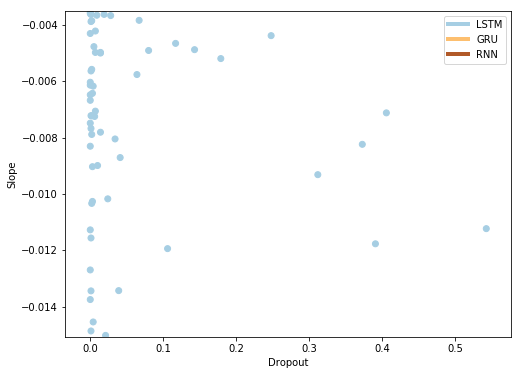

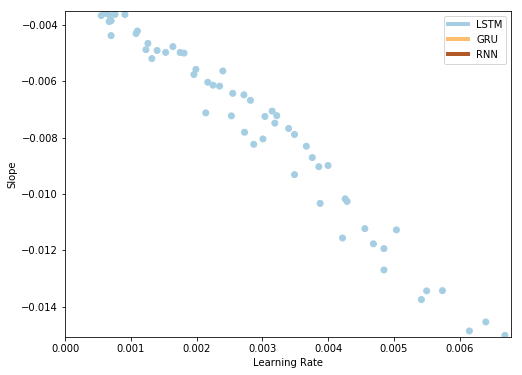

In [21]:
fig = plt.figure(figsize = (8,6))
cmap = cm.get_cmap('Paired')
plt.scatter(dos, slopes2, cmap = cmap, c = [model[0] for model in models])
plt.ylim([min(slopes2)-.00005, max(slopes2)+.00005])
# plt.colorbar()
legend_elements = [Line2D([0], [0], color= cmap(0), lw=4, label='LSTM'),
                   Line2D([0], [0], color= cmap(1/2), lw=4, label='GRU'),
                   Line2D([0], [0], color= cmap(2/2), lw=4, label='RNN')]
plt.legend(handles = legend_elements)
plt.xlabel('Dropout')
plt.ylabel('Slope')

fig = plt.figure(figsize = (8,6))
cmap = cm.get_cmap('Paired')
norm = matplotlib.colors.BoundaryNorm([0,1,2], cmap.N)
plt.scatter(lrs, slopes2, cmap = cmap, c = [model[0] for model in models])
plt.ylim([min(slopes2)-.00005, max(slopes2)+.00005])
plt.xlim([0, max(lrs)+.0001])
# plt.colorbar()

plt.legend(handles = legend_elements)
plt.xlabel('Learning Rate')
plt.ylabel('Slope')

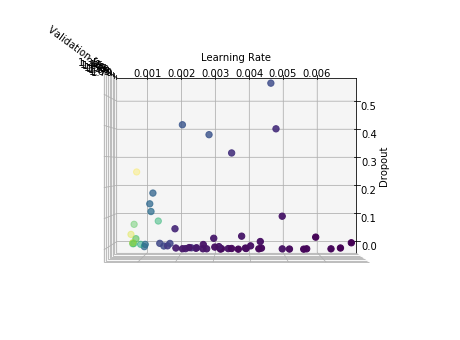

In [45]:
X, Y = np.meshgrid(dos, lrs)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(dos, lrs, val_losses, s = 40, c = val_losses)
ax.set_xlabel('Dropout')
ax.set_ylabel('Learning Rate')
# ax.set_zlabel('Validation Loss')
# ax.view_init(-90, 0)

Text(0.5, 1.0, 'Slopes for Indices 200-300')

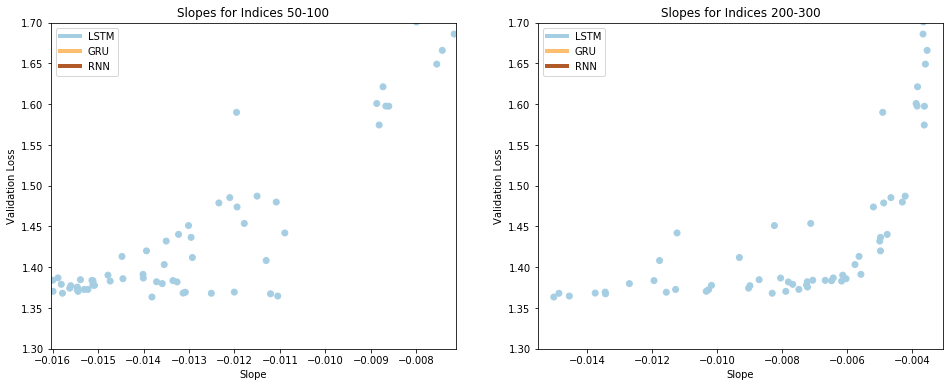

In [22]:
plt.figure(figsize = (16,6))
plt.subplot(121)
plt.scatter(slopes, val_losses, cmap = cmap, c = [model[0] for model in models])
plt.xlim([min(slopes) - .00005, max(slopes) + .00005])
# plt.xlim([-.015, max(slopes) + .0005])
plt.ylim([1.3, 1.7])
plt.legend(handles = legend_elements)
plt.xlabel('Slope')
plt.ylabel('Validation Loss')
plt.title('Slopes for Indices 50-100')

plt.subplot(122)
plt.scatter(slopes2, val_losses, cmap = cmap, c = [model[0] for model in models])
# plt.xlim([-.015, max(slopes2) + .00005])
plt.xlim([min(slopes2) - .0005, max(slopes2) + .0005])
plt.ylim([1.3, 1.7])
plt.legend(handles = legend_elements)
plt.xlabel('Slope')
plt.ylabel('Validation Loss')
plt.title('Slopes for Indices 200-300')

In [ ]:
def angles(LE, k = 1):
    slope = (LE[1:] - LE[:-1])
    return np.arctan(k/slope)

In [ ]:
angles(np.array([1, 2, 5, 6, 8]))

In [ ]:
np.shape(r_idcs)

In [ ]:
np.tri(5, 5, k=1) - np.tri(5, 5, k = -2) - 3*np.eye(5)

In [ ]:
def D2(y_list, h = 1):
#     l = len(y_list)
#     n = len(y_list[0])
#     d2 = 1/(h**2)*(np.eye(n, k=1) + np.tri(n, k = -1) - 2*np.eye(n))

    return [np.gradient(np.gradient(y)) for y in y_list]

def D1(y_list, h=1):
#     l = len(y_list)
#     n = len(y_list[0])
#     d1 = 1/h*(np.eye(n, k=1) - np.eye(n, k = -1))
    return [np.gradient(y) for y in y_list]

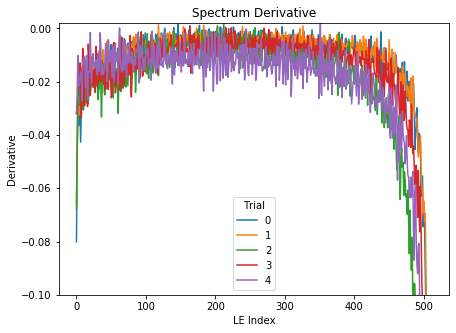

In [23]:
plt.figure(figsize = (7,5))
for idx in range(5):
    plt.plot(np.gradient(LE_means[idx]), label = idx)
plt.title('Spectrum Derivative'.format(idx))
plt.ylabel('Derivative')
plt.xlabel('LE Index')
plt.ylim([-.1, 0.002])
plt.legend(title = 'Trial')

Text(0, 0.5, 'Validation Loss')

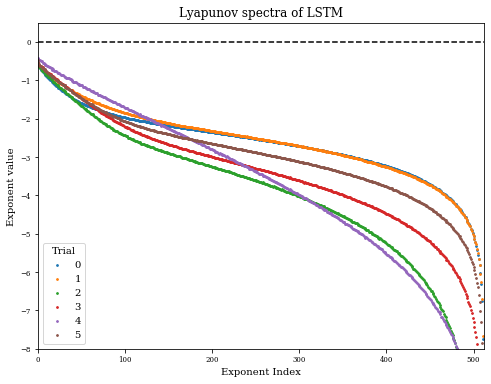

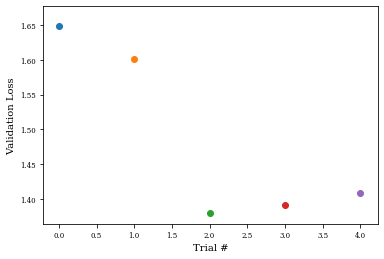

In [49]:
plt.figure(figsize = (4,3))
for idx in range(6):
    plt.scatter(range(0,512), LE_means[idx], s = 3, label = idx)
plt.plot([0, 512], [0, 0], 'k--')
# plt.title('Lyapunov spectra of LSTM')
plt.ylabel('Exponent value')
plt.xlabel('Exponent index')
plt.ylim([-8, 0.5])
plt.xlim([0, 512])
plt.legend(title = 'Trial')
plt.savefig()

plt.figure(figsize = (4,3))
for i in range(5):
    plt.scatter(i, val_losses[i])
plt.xlabel('Trial #')
plt.ylabel('Validation Loss')


In [ ]:
k = 1
plt.figure(figsize = (8, 6))
max_angles = np.array([max(abs(angles(LE_mean, k))) for LE_mean in LE_means]) 
# plt.subplot(121)
plt.scatter(max_angles, val_losses)
plt.xlim([min(max_angles), max(max_angles)])
plt.ylabel('Validation Loss')
plt.xlabel('Maximum Angle')

plt.title('Maximum angle with Vertical and Validation Loss')

# plt.subplot(122)
# plt.scatter(range(len(max_angles)), max_angles)

In [ ]:
np.where(max_angles <= min(max_angles) + .012)

In [ ]:
fig = plt.figure(figsize = (8,6))
k = 0.01
for idx in range(5):
    plt.plot(abs(angles(LE_means[idx], k)), label = idx)

plt.legend(title = 'Trial')
plt.xlabel('LE Index')
plt.ylabel('Angle to vertical (radians)')
plt.title('Angle measurements of LE spectra, with k = {}'.format(k))
# plt.ylim([1.5, np.pi/2 + .001])

In [ ]:
coefs = np.zeros((len(LE_means), 4))
for i, LE_mean in enumerate(LE_means):
    coefs[i, :] = np.polyfit(range(512), LE_mean, deg = 3)
print(coefs)

In [ ]:
np.polyfit(range(512), LE_mean, deg = 3).shape

In [ ]:
c1s = coefs[:,0]
c2s = coefs[:,1]
c3s = coefs[:,2]
c4s = coefs[:,3]
print(c1s)

In [ ]:
cs = c3s
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.scatter(cs, val_losses)
plt.xlim([min(cs), max(cs)])
plt.ylim([min(val_losses)-.01, 1.4])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c1s, c2s, val_losses)
plt.xlim([min(c1s), max(c1s)])
plt.ylim([min(c2s), max(c2s)])
ax.set_xlabel('Cubic')
ax.set_ylabel('Quadratic')
ax.set_zlabel('Validation Loss')
ax.view_init(30, 10)

In [ ]:
x=  np.array(range(512))
x_poly = np.array([[x**3],[x**2],[x**1],[x**0]]).squeeze()

In [ ]:
a1 = (a * np.array([3, 2, 1, 0]))[:-1]
a2 = (a1*np.array([2, 1, 0]))[:-1]
d1 = x_poly[1:, :].T @ a1
d2 = x_poly[2:, :].T@a2

In [ ]:
plt.plot(d2 / np.power(1+ d1*d1, 3/2))

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(c1s, val_losses)
plt.xlim([min(c1s), max(c1s)])
plt.title('Slope of Curvature vs Validation Loss')
plt.xlabel('Curvature Slope')
plt.ylabel('Validation Loss')

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(c2s, val_losses)
plt.xlim([min(c2s), max(c2s)])
plt.title('y-intercept of Curvature vs Validation Loss')
plt.xlabel('Curvature Intercept')
plt.ylabel('Validation Loss')

In [ ]:
idxs = list(range(60))
diffs = np.zeros((len(idxs), 512))
a_array = np.zeros((len(idxs), 4))
# plt.figure(figsize = (8,12))
for i in idxs:
    a = np.polyfit(range(512), LE_means[i], deg = 3)
    diffs[i, :] = np.matmul(x_poly.T, a) - np.array(LE_means[i])
    a_array[i, :] = a
#     plt.plot(np.matmul(x_poly.T, a) - np.array(LE_means[idx]))
    
#     plt.scatter(range(0,512), LE_means[idx], s = 3)
# plt.xlim([0, 300])
# plt.ylim([-1, 1])
# plt.xlabel('LE Index')
# plt.ylabel('LE Value')
# plt.title('3rd-degree Polynomial fits'.format(idx))

In [ ]:
idxs = [4, 43, 38, 36, 31, 16]
plt.figure(figsize = (16, 12))
plt.subplot(121)
for idx in idxs:

#     diffs[i, :] = np.matmul(x_poly.T, a) - np.array(LE_means[i])
    a = a_array[idx, :]
    plt.plot(np.matmul(x_poly.T, a), label = str(idx))
    plt.scatter(range(0,512), LE_means[idx], s = 3)
plt.xlim([0, 512])
plt.ylim([-8, 0.5])
plt.xlabel('LE Index')
plt.ylabel('LE Value')
plt.title('3rd-degree Polynomial fits'.format(idx))
plt.legend(title = 'Trial')

plt.subplot(122)
for idx in idxs:

#     diffs[i, :] = np.matmul(x_poly.T, a) - np.array(LE_means[i])
#     a = a_array[idx, :]
    plt.plot(diffs[idx, :], label = idx)
plt.ylim([-1, 1])
plt.xlabel('LE Index')
plt.ylabel('Polynomial Error')
plt.title('3rd-degree Polynomial Errors'.format(idx))
plt.legend(title = 'Trial')
#     plt.scatter(range(0,512), LE_means[idx], s = 3)

In [ ]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
max_idcs = range(100, 500, 10)

# max_idcs = [100, 250]
xs = np.array(max_idcs)
ys = np.array(val_losses)
zs = np.zeros((len(val_losses), len(max_idcs)))
for i, max_idx in enumerate(max_idcs):
    zs[:, i] = np.sum(diffs[:, :max_idx]**2, axis = 1)/max_idx
#     ax.scatter(np.sum(diffs[:, :max_idx]**2, axis = 1)/max_idx, val_losses, label = max_idx)
X, Y = np.meshgrid(xs, ys)
ax.scatter(X, Y, zs, c = X.flatten())
# plt.show()
# print(X.shape)
# print(Y.shape)
# print(zs.shape)
# print(zs)
# ax.set_xscale('log')
# ax.set_zscale('log')
# ax.set_yscale('log')
# ax.set_title('Mean Squared error of polynomial fit vs. Validation Loss')
ax.set_ylabel('Valdiation Loss')
ax.set_xlabel('Maximum Index')
ax.set_zlabel('Mean Squared Error')

ax.view_init(30, 150)
# ax.plot([0, 1], [min(val_losses), min(val_losses)], 'k--', label = 'Min Loss')
# ax.legend()

In [ ]:
fig = plt.figure(figsize = (8,6))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
max_idcs = range(10, 100)

max_idcs = [100, 250, 500]
xs = np.array(max_idcs)
ys = np.array(val_losses)
zs = np.zeros((len(val_losses), len(max_idcs)))
for i, max_idx in enumerate(max_idcs):
#     zs[:, i] = np.sum(diffs[:, :max_idx]**2, axis = 1)/max_idx
    ax.scatter(np.sum(diffs[:, :max_idx]**2, axis = 1)/max_idx, val_losses, label = max_idx)
# X, Y = np.meshgrid(xs, ys)
# ax.scatter(X, Y, zs)
# plt.show()
# print(X.shape)
# print(Y.shape)
# print(zs.shape)
# print(zs)
ax.set_title('Mean Squared error of polynomial fit vs. Validation Loss')
ax.set_xlabel('Mean Squared Error (Logarithmic Scale)')
ax.set_ylabel('Validation loss (Logarithmic Scale)')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.view_init(10, 30)
# ax.plot([0, 1], [min(val_losses), min(val_losses)], 'k--', label = 'Min Loss')
# ax.legend()

In [ ]:
X, Y = np.meshgrid(xs, ys)

In [ ]:
X.shape

In [ ]:
(diffs[:, :2]**2).shape

Text(0.5, 1.0, 'LSTM LE Spectrum Slope vs Validation Loss')

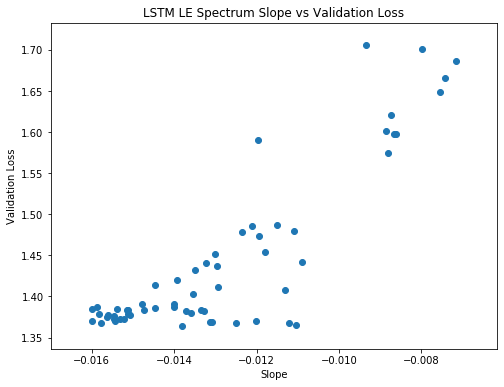

In [28]:
plt.figure(figsize = (8,6))
plt.scatter(slopes, val_losses)
plt.xlim([min(slopes)-.001, max(slopes)+.001])
plt.xlabel('Slope')
plt.ylabel('Validation Loss')
plt.title('LSTM LE Spectrum Slope vs Validation Loss')

In [ ]:
idx = 4

LE_means = [LE[0] for LE in LEs]
second = D2(LE_means, h = 1)


a = np.polyfit(range(512), LE_means[idx], deg = 3)

a1 = (a * np.array([3, 2, 1, 0]))[:-1]
a2 = (a1*np.array([2, 1, 0]))[:-1]
d1 = x_poly[1:, :].T @ a1
d2 = x_poly[2:, :].T@a2


fig = plt.figure(figsize = (8,6))
# plt.plot(second[0])
# plt.ylim([-.05, 1])
# dy = D1(LE_means)
# dy2 = D2(LE_means)
# print(np.abs(dy2[0]) / np.power(np.abs(dy[0]), 3))
# for i in [4, 43, 38, 36, 31, 16]:
for i in [3, 33, 13, 52, 22, 7]:
    a = np.polyfit(range(512), LE_means[i], deg = 3)
    print(2*a[1])
    a1 = (a * np.array([3, 2, 1, 0]))[:-1]
    a2 = (a1*np.array([2, 1, 0]))[:-1]
    d1 = x_poly[1:, :].T @ a1
    d2 = x_poly[2:, :].T@a2
    curve = d2 / np.power(1+ d1*d1, 3/2)
    print(curve[0])
    plt.plot(curve, label = str(i))
    
plt.xlim([0,512])
plt.ylim([-.0005,0.0005])
plt.legend()
plt.plot([0,512], [0,0], 'k--')
plt.xlabel('LE Index')
plt.ylabel('Curvature')
plt.title('Curvature of 3rd-degree polynomial for different LE spectra')
# np.abs(d2) / np.power(np.abs(d1)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(2,512), second[idxs[0]][1:-1])
plt.plot(range(2,512), second[idxs[1]][1:-1])
plt.xlim([0, 400])
plt.ylim(min(second[0][1:400]), max(second[0][1:400]))
plt.plot([0,512], [0,0], 'k--')

In [ ]:
plt.figure(figsize = (6, 10))
plt.scatter(range(0,512), LE_means[idxs[0]])
plt.scatter(range(0,512), LE_means[idxs[1]])
plt.ylim([-8, 0.5])

In [ ]:
l = len(LEs)
n = len(LEs[0][0])
print(str(l) + ' ' + str(n))

In [ ]:
y_spl_2d = y_spl.derivative(n=2)

plt.plot(x_range[0:100],y_spl_2d(x_range[0:100]))

In [ ]:
# indices = np.random.randint(low = 0, high = len(trials), size = 6)
for row in r_idcs:
    fig = plt.figure(figsize =(20,10))

    a = [235, 234, 232, 231]


    plt.subplot(a[0])
    plt.xlabel('Exponent #')
    plt.xlim([200, 300])
    plt.ylim([-4, .5])
#     plt.ylim([-2.15, -2])
    plt.ylabel('Lyapunov Exponent Value')

    plt.subplot(133)
    plt.xlabel('Exponent #')
    plt.xlim([0, 597])
#     plt.ylim([-2.5, .5])
    plt.ylim([-8, 0.5])
    plt.ylabel('Lyapunov Exponent Value')

    plt.subplot(a[2])
    plt.xlabel('Exponent #')
    plt.xlim([50, 100])
    plt.ylim([-2.5, 0.5])
    # plt.ylim([-2.2, -1.9])
    plt.ylabel('Lyapunov Exponent Value')


    plt.subplot(a[1])
    plt.xlabel('Slope')
    plt.xlim([min(slopes)-.005, max(slopes)+.005])
    plt.ylim([min(val_losses)-.005, max(val_losses)+.005])
    plt.ylabel('Validation Loss')

    plt.subplot(a[3])
    plt.xlabel('Slope')
    plt.xlim([min(slopes)-.005, max(slopes)+.005])
    plt.ylim([-.05, 2.05])
    plt.yticks(ticks = [0, 1, 2], labels = ['LSTM', 'GRU', 'RNN'])
    plt.ylabel('Model Type')


    idcs = ''
    for idx in row:
        idcs = idcs +  str(idx) + '_'
        cmap = cm.get_cmap('Paired')
        t_vals = trials.trials[idx]['misc']['vals']
        net_type, size, suf = model_idx(t_vals['net_settings'])
        con = Config(model_dir = model_dir, rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], optimizer = 'adam', max_epochs = 4)

        k_LE = min(con.hidden_size*con.num_layers, 100000)
        LE_mean, LE_std = LEs[idx]
#         print(LE_mean)
        val_loss = val_losses[idx]
        slope = slopes[idx]
        x = np.linspace(0, k_LE-1, k_LE)
        hidden_size = con.hidden_size
        num_layers = con.num_layers

        plt.subplot(a[0]);
        label = '{:.6f}'.format(slope)
        for j in range(con.num_layers):
            plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=0*LE_mean[:k_LE].to(torch.device('cpu')), marker = '.', linestyle = ' ', markersize = 6.5, elinewidth = 2, label = label)#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)

        plt.subplot(a[2]);
        label = '{:.6f}'.format(slope)
        for j in range(con.num_layers):
            plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=0*LE_mean[:k_LE].to(torch.device('cpu')), marker = '.', linestyle = ' ', markersize = 6.5, elinewidth = 2, label = label)#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)


        plt.subplot(a[1]);
        plt.scatter(slope, val_loss, s = 50, label = idx)
    #     plt.legend(title = 'Trial #')


        plt.subplot(a[3])
        plt.scatter(slope, models[idx][0], label = idx, s = 80)
    #     plt.legend(title = 'Trial #')

        plt.subplot(133);
        label = '{:.6f}'.format(slope)
        for j in range(con.num_layers):
            plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=0*LE_mean[:k_LE].to(torch.device('cpu')), marker = '.', linestyle = ' ', markersize = 6.5, elinewidth = 2, label = label)#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)



    plt.subplot(a[0]);
    plt.plot([0,num_layers*np.max([k_LE, 597, 512])], [0,0], 'k--')
    plt.legend(title = 'Slope', loc = 1);

    plt.subplot(a[1])
    plt.legend(title = 'Trial #')

    plt.subplot(133);
    plt.plot([0,num_layers*np.max([k_LE, 597, 512])], [0,0], 'k--')
    plt.legend(title = 'Slope', loc = 3);

    plt.subplot(a[2]);
    plt.plot([0,num_layers*np.max([k_LE, 597, 512])], [0,0], 'k--')
    plt.legend(title = 'Slope', loc = 1);

    fig.savefig('{}/LyapunovPlots_Trials{}.png'.format(con.data_dir, idcs))
    

#     plt.xlabel('Exponent #')
#     plt.xlim([0, 597])
#     # plt.ylim([-2.5, .5])
#     plt.ylim([-12, 0.5])
#     plt.ylabel('Lyapunov Exponent Value')

In [ ]:
trials.trials[idx]['tid']

In [ ]:
best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LEs[4][0][slope_inds[0]:slope_inds[1]])

In [ ]:
print((LEs[4][0][100] - LEs[4][0][50])/50)
print((LEs[25][0][100] - LEs[25][0][50])/50)
print((LEs[16][0][100] - LEs[16][0][50])/50)
print((LEs[20][0][100] - LEs[20][0][50])/50)

In [ ]:
plt.figure("Lyap Trials")

In [ ]:
np.random.shuffle(np.array(range(n)))

In [ ]:
def load_con(trials, idx, max_epochs = 4):
    t_vals = trials.trials[idx]['misc']['vals']
    net_type, size, suf = model_idx(t_vals['net_settings'])
    return Config(rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], optimizer = 'adam', max_epochs = 4)


In [ ]:
con = load_con(trials, 4)

net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(4)))
a1 = net.rnn_layer.all_weights[0][1].detach()

con = load_con(trials, 17)

net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(4)))
a2 = net.rnn_layer.all_weights[0][1].detach()

In [ ]:
plt.matshow(net.rnn_layer.all_weights[0][1].detach())
plt.colorbar()

In [ ]:
con = load_con(trials, 17)

net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(4)))

In [ ]:
plt.plot(a1.reshape((-1,4)) - a2.reshape((-1,4)))

In [ ]:
net.rnn_layer.all_weights[0][1].detach().reshape((-1,))

In [ ]:
con = load_con(trials, 17)

net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(4)))
plt.plot(net.rnn_layer.all_weights[0][1].detach().reshape((-1,4)))

In [ ]:
a1.reshape((-1,4))

In [ ]:
LE_list = []
slope_indices = [50, 100]
for idx, trial in enumerate(trials):
    if idx == 4 or idx == 17:
        t_vals = trials.trials[idx]['misc']['vals']
        net_type, size, suf = model_idx(t_vals['net_settings'])
        con = Config(rnn_model = net_type, hidden_size = size, dropout = t_vals['do_{}'.format(suf)][0], learning_rate = t_vals['lr_{}'.format(suf)][0], optimizer = 'adam', max_epochs = 4)
        net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
        con.batch_size = 10
        loss, LEs = le_loss(net, con, slope_indices, dynamics = False)
        LE_list.append(LEs)
        print(loss)
        LE_mean, LE_std = LEs
        for j in range(con.num_layers):
            plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=LE_std[:k_LE].to(torch.device('cpu')), marker = '.', linestyle = ' ', markersize = 6.5, elinewidth = 2, label = label)#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)


In [ ]:
for LEs in LE_list:
    for j in range(con.num_layers):
        plt.errorbar(x+j*k_LE, LE_mean[j*hidden_size:k_LE+j*hidden_size].to(torch.device('cpu')), yerr=0*LE_mean[:k_LE].to(torch.device('cpu')), marker = '.', linestyle = ' ', markersize = 6.5, elinewidth = 2, label = label)#'epoch {}'.format(i) if (j==0 and epoch%2 == 0) else None)


In [ ]:
plt.gca()

In [47]:
thresh3 = []
for LE_mean in LE_means:
#     print(LE_mean.shape)
    thresh3.append(sum(np.array(LE_mean>-3, dtype = int)))
#     print(sum(np.array(LE_mean>-3, dtype = int)))
thresh3 = np.array(thresh3)

## Generate Plots for sharing

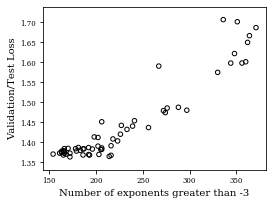

In [58]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(thresh3, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Number of exponents greater than -3')
ax.set_ylabel('Validation/Test Loss')
plt.savefig("Thresh_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

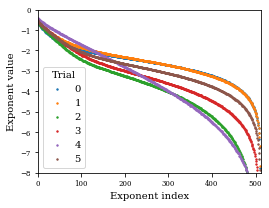

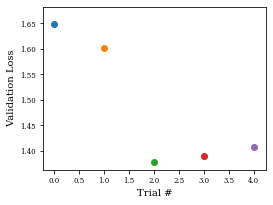

In [66]:
plt.figure(figsize = (4,3))
for idx in range(6):
    plt.scatter(range(0,512), LE_means[idx], s = 2, label = idx)
# plt.plot([0, 512], [0, 0], 'k--')
# plt.title('Lyapunov spectra of LSTM')
plt.ylabel('Exponent value')
plt.xlabel('Exponent index')
plt.ylim([-8, 0])
plt.xlim([0, 512])
plt.legend(title = 'Trial')
plt.savefig("Trial Spectra.png",bbox_inches="tight",dpi=400, format = 'png')

plt.figure(figsize = (4,3))
for i in range(5):
    plt.scatter(i, val_losses[i])
plt.xlabel('Trial #')
plt.ylabel('Validation Loss')
plt.savefig("Trial Validation Loss.png",bbox_inches="tight",dpi=400, format = 'png')

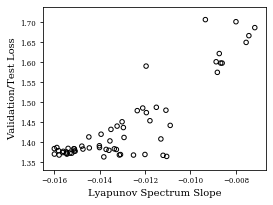

In [67]:
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(slopes, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Lyapunov Spectrum Slope')
ax.set_ylabel('Validation/Test Loss')
ax.set_xlim([min(slopes) - .0005, max(slopes) + .0005])
plt.savefig("Slopes_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

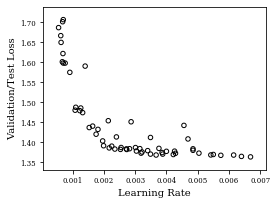

In [78]:
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(lrs, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation/Test Loss')
ax.set_xlim([min(lrs) - .0005, max(lrs) + .0005])
# ax.set_xscale('log')
plt.savefig("LR_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

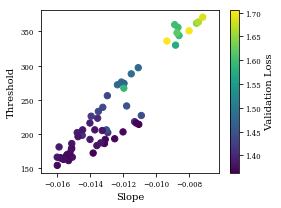

In [83]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(111)#, projection = '2d')
plt.scatter(slopes, thresh3, s = 40, c = val_losses)
# ax.set_xlabel('Slope')
# ax.set_ylabel('Threshold')
# ax.set_xlim([min(slopes)-.001, max(slopes)+.001])
plt.xlabel('Slope')
plt.ylabel('Threshold')
plt.xlim([min(slopes)-.001, max(slopes)+.001])
cbar = plt.colorbar()
cbar.set_label("Validation Loss")
# ax.set_zlabel('Validation Loss')
# ax.view_init(90, 90)

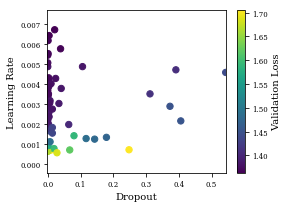

In [84]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(111)#, projection = '2d')
plt.scatter(dos, lrs, s = 40, c = val_losses)
# ax.set_xlabel('Slope')
# ax.set_ylabel('Threshold')
# ax.set_xlim([min(slopes)-.001, max(slopes)+.001])
plt.xlabel('Dropout')
plt.ylabel('Learning Rate')
plt.xlim([min(dos)-.001, max(dos)+.001])
plt.ylim([min(lrs)-.001, max(lrs)+.001])
cbar = plt.colorbar()
cbar.set_label("Validation Loss")
# ax.set_zlabel('Validation Loss')
# ax.view_init(90, 90)